# Off-Policy MC with Weighted Importance Sampling on Blackjack
Based on: https://github.com/dennybritz/reinforcement-learning/tree/master/MC

In [20]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
%run blackjack.py 
%run plotting.py

matplotlib.style.use('ggplot')

In [21]:
env = BlackjackEnv()

In [22]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [33]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        nextActions = np.zeros_like(Q[state], dtype = float)
        bestAction = np.argmax(Q[state])
        nextActions[bestAction] = 1.0 
        return nextActions  
    return policy_fn

In [38]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Generate i_episode episodes 
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # Make new episode
        episode = [] 
        
        # Reset environment
        state = env.reset()
        
        # Generate 100 time-steps using random behavior policy 
        for time in range(100):
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            nextState, reward, done, _ = env.step(action)
            
            # Append SAR to episode 
            episode.append((state, action, reward))
            
            # If terminal state, go to next episode 
            if done: 
                break 
                
            # Update state
            state = nextState 
            
        # Sum of discounted returns
        G = 0.0
        
        # Numerator: Importance sampling ratio (weights of returns)
        W = 1.0 
        
        # Go in reverse and find Q-value for each SA pair 
        for t in range(len(episode))[::-1]: 
            state, action, reward = episode[t]
            
            # Update the total reward since step t
            G = discount_factor * G + reward 
            
            # Denominator (sum of weights)
            C[state][action] += W 
            
            # Update action-value function with incremental update formula 
            Q[state][action] += (W/C[state][action]) * (G - Q[state][action])
            
            # If the action at t does not match in terms of behavior vs. target, then stop the updates for this episode.
            if action != np.argmax(target_policy(state)):
                break
                
            # Update weighted importance
            W = W * 1./behavior_policy(state)[action]
                   
    return Q, target_policy

In [39]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

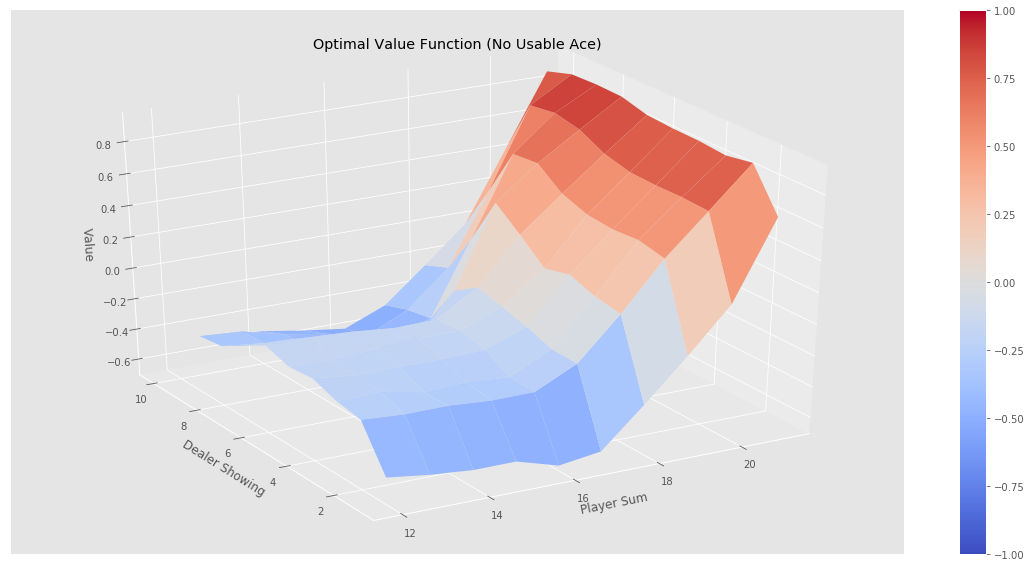

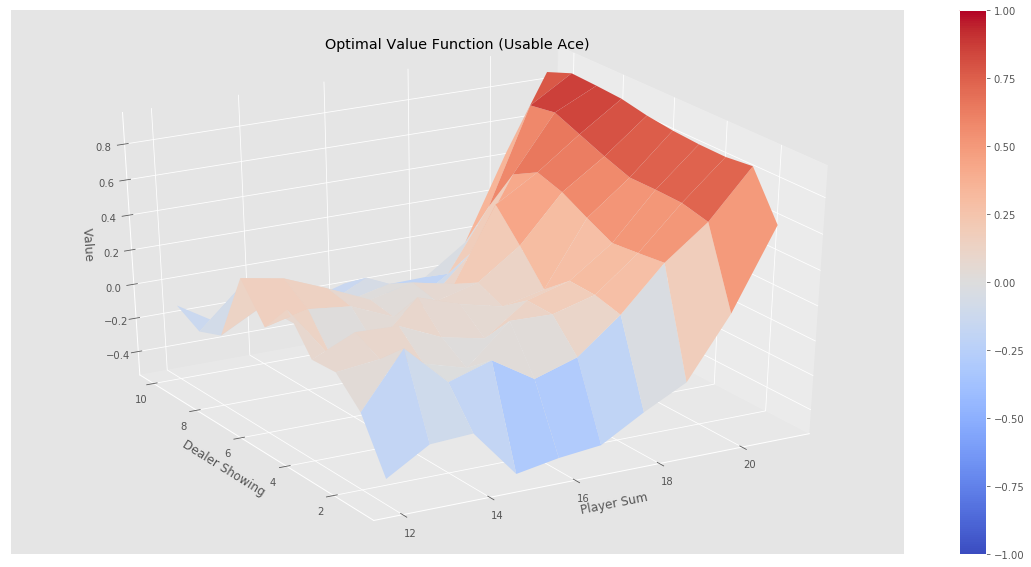

In [40]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")